In [1]:
# Standard library imports
from pathlib import Path
import warnings

# Data science libraries
import pandas as pd
import numpy as np
from scipy import stats

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from cycler import cycler
import seaborn as sns

# Optional: For interactive elements
from IPython.display import display

# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("All libraries loaded successfully!")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


All libraries loaded successfully!
Matplotlib version: 3.10.3
Pandas version: 2.3.0
NumPy version: 2.2.6


## 🎨 Custom Color Palette

Professional color palette organized by hue families for better visual harmony and accessibility.


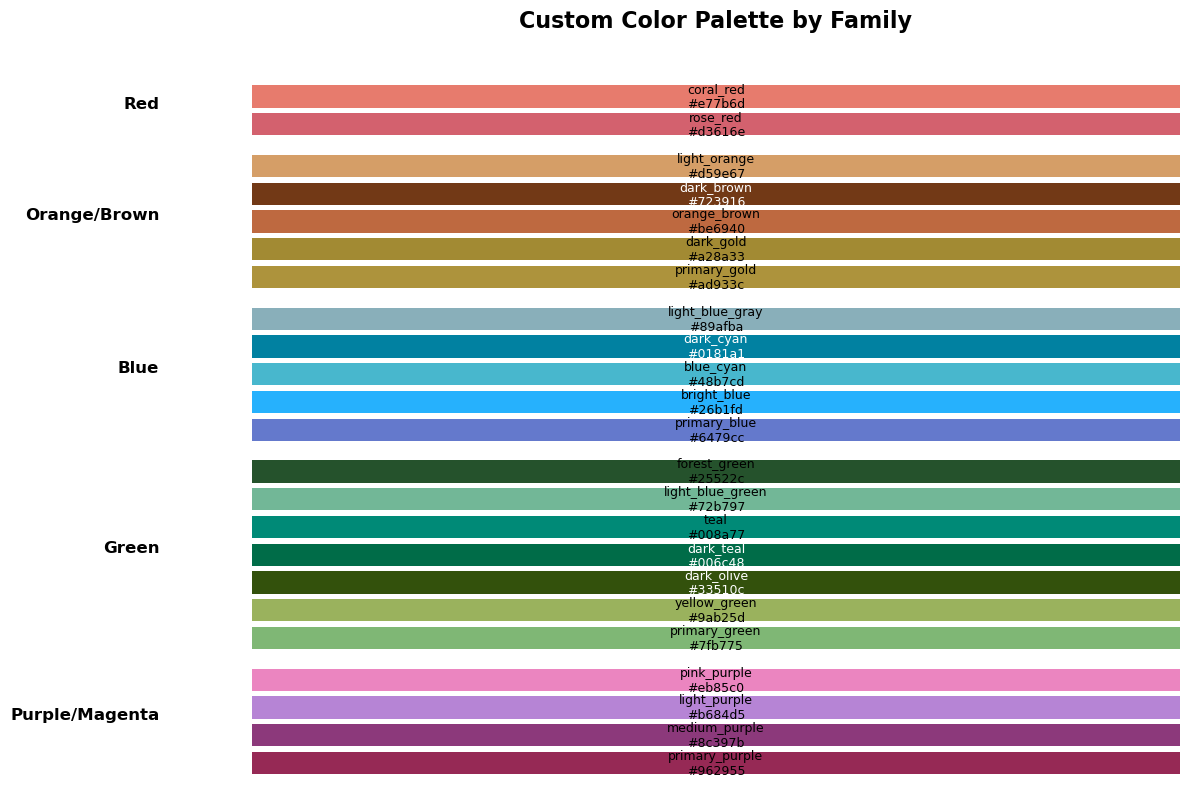

Color palette loaded successfully!
Primary trio: ['#962955', '#7fb775', '#6479cc']
Four-category palette: ['#962955', '#7fb775', '#6479cc', '#ad933c']


In [2]:
# Custom Color Palette - Organized by families
COLORS = {
    # Purple/Magenta Family (4 colors)
    'primary_purple': '#962955',    # Deep pink-purple (primary choice)
    'medium_purple': '#8c397b',     # Medium purple
    'light_purple': '#b684d5',      # Light purple
    'pink_purple': '#eb85c0',       # Pink-purple
    
    # Green Family (7 colors)
    'primary_green': '#7fb775',     # Medium green (primary choice)
    'yellow_green': '#9ab25d',      # Yellow-green
    'dark_olive': '#33510c',        # Dark olive green
    'dark_teal': '#006c48',         # Dark teal-green
    'teal': '#008a77',              # Teal
    'light_blue_green': '#72b797',  # Light blue-green
    'forest_green': '#25522c',      # Forest green
    
    # Blue Family (5 colors)
    'primary_blue': '#6479cc',      # Medium blue (primary choice)
    'bright_blue': '#26b1fd',       # Bright blue
    'blue_cyan': '#48b7cd',         # Blue-cyan
    'dark_cyan': '#0181a1',         # Dark cyan
    'light_blue_gray': '#89afba',   # Light blue-gray
    
    # Orange/Brown Family (5 colors)
    'primary_gold': '#ad933c',      # Golden brown (primary choice)
    'dark_gold': '#a28a33',         # Dark gold
    'orange_brown': '#be6940',      # Orange-brown
    'dark_brown': '#723916',        # Dark brown
    'light_orange': '#d59e67',      # Light orange
    
    # Red Family (2 colors)
    'rose_red': '#d3616e',          # Rose red
    'coral_red': '#e77b6d',         # Coral red
}

# Recommended color combinations
PRIMARY_TRIO = [COLORS['primary_purple'], COLORS['primary_green'], COLORS['primary_blue']]
FOUR_CATEGORY = PRIMARY_TRIO + [COLORS['primary_gold']]
SIX_CATEGORY = FOUR_CATEGORY + [COLORS['bright_blue'], COLORS['medium_purple']]

# Set as default matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=PRIMARY_TRIO)

# Display color palette
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
families = {
    'Purple/Magenta': ['primary_purple', 'medium_purple', 'light_purple', 'pink_purple'],
    'Green': ['primary_green', 'yellow_green', 'dark_olive', 'dark_teal', 'teal', 'light_blue_green', 'forest_green'],
    'Blue': ['primary_blue', 'bright_blue', 'blue_cyan', 'dark_cyan', 'light_blue_gray'],
    'Orange/Brown': ['primary_gold', 'dark_gold', 'orange_brown', 'dark_brown', 'light_orange'],
    'Red': ['rose_red', 'coral_red']
}

y_pos = 0
for family_name, color_names in families.items():
    for i, color_name in enumerate(color_names):
        ax.barh(y_pos, 1, color=COLORS[color_name], height=0.8)
        ax.text(0.5, y_pos, f'{color_name}\n{COLORS[color_name]}', 
               ha='center', va='center', fontsize=9, 
               color='white' if color_name in ['dark_olive', 'dark_teal', 'dark_cyan', 'dark_brown'] else 'black')
        y_pos += 1
    y_pos += 0.5  # Add space between families
    
    # Add family label
    ax.text(-0.1, y_pos - len(color_names)/2 - 0.75, family_name, 
           ha='right', va='center', fontsize=12, weight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, y_pos)
ax.set_title('Custom Color Palette by Family', fontsize=16, weight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Color palette loaded successfully!")
print(f"Primary trio: {PRIMARY_TRIO}")
print(f"Four-category palette: {FOUR_CATEGORY}")


## ⚙️ Professional Styling Configuration

Set up consistent, publication-ready styling for all plots.


In [3]:
# Professional styling configuration
def setup_plot_style():
    """Configure matplotlib with professional, publication-ready defaults."""
    
    # General appearance
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'savefig.dpi': 300,
        'figure.dpi': 100,
        
        # Typography
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.titlesize': 14,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'axes.labelweight': 'semibold',
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # Line and marker properties
        'axes.linewidth': 1.2,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'patch.linewidth': 1.2,
        
        # Spine and tick properties
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.bottom': True,
        'xtick.top': False,
        'ytick.left': True,
        'ytick.right': False,
        
        # Grid properties
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'axes.axisbelow': True,
        
        # Legend properties
        'legend.frameon': False,
        'legend.numpoints': 1,
        'legend.scatterpoints': 1,
    })

def clean_axes(ax):
    """Apply clean styling to axes - removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.grid(True, alpha=0.3, linewidth=0.8)
    return ax

def add_stats_annotation(ax, text, x=0.05, y=0.95):
    """Add statistical annotation to plot."""
    ax.text(x, y, text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
           verticalalignment='top', fontsize=9)

def save_plot(fig, filename, formats=['png', 'svg'], dpi=300):
    """Save plot in multiple formats with consistent settings."""
    for fmt in formats:
        filepath = Path(f"{filename}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    print(f"Plot saved as: {', '.join([f'{filename}.{fmt}' for fmt in formats])}")

# Apply the styling
setup_plot_style()
print("Professional styling configuration applied!")

# Standard figure sizes for different use cases
FIGURE_SIZES = {
    'small': (4, 3),      # Single plots, supplements
    'medium': (6, 4.5),   # Standard journal figures  
    'large': (8, 6),      # Complex plots with multiple elements
    'wide': (10, 4),      # Time series, genomic data
    'square': (4, 4),     # Correlation plots, heatmaps
}

print("Available figure sizes:", list(FIGURE_SIZES.keys()))


Professional styling configuration applied!
Available figure sizes: ['small', 'medium', 'large', 'wide', 'square']


# 1.Load data

In [4]:
annotations = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/12_concatenated/annotations.tsv", sep="\t", index_col=[0,1,2,3])
insertion_level_LFCs = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/16_insertion_level_curve_fitting/insertions_LFC_fitted.tsv", sep="\t", index_col=[0,1,2,3])
gene_level_LFCs = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", sep="\t", index_col=0)

genes_with_wrong_DIT_HAP = [
    "hul6",
    "sca1",
    "pmc3",
    "ymr1",
    "mkh1",
    "msn5",
    "tsc2",
    "phi1",
    "mal1",
    "num1",
    "vps1301",
    "SPCC24B10.18",
]

selected_genes = [
    "alm1",
    "atp25",
    "bst1",
    "cdc12",
    "cdc15",
    "cdc7",
    "cdk9",
    "cid14",
    "cog6",
    "cwf24",
    "cwf3",
    "dbl2",
    "dcp1",
    "dfr1",
    "esf1",
    "eso1",
    "fcp1",
    "gmh4",
    "gpi17",
    "gpi18",
    "hfi1",
    "hsf1",
    "its3",
    "mcm4",
    "mdm34",
    "met9",
    "mis6",
    "mms19",
    "mre11",
    "nbs1",
    "not1",
    "nup189",
    "pan1",
    "peg1",
    "pep3",
    "rib2",
    "rib7",
    "rlp7",
    "rpt2",
    "sec8",
    "sip1",
    "sog2",
    "spt7",
    "ssr2",
    "tfg1",
    "tif471",
    "tpr1",
    "uba2",
    "vps11",
    "vps16",
    "lsh1",
    "cdc12",
    "gpi18",
    "cid14",
    "efg1",
    "tup12",
    "mrp11",
    "atp25",
    "mre11",
    "sld3",
    "wrs1",
    "prh1",
    "mis6",
    "meu31",
    "met9",
    "cdc15",
    "taf2",
    "cdc123",
    "vps41",
    "bst1",
    "rlp7",
    "bfr2",
    "ulp2",
    "swc4",
    "rpn9",
    "pst2",
    "fta2",
    "cit1",
    "trl1",
    "ssr2",
    "vps11",
    "rpp101",
    "vma5",
    "abo1",
    "peg1",
    "ntr1",
    "alm1",
    "nup189",
    "sen1",
    "rpl702",
    "mms19",
    "pub1",
    "its3",
    "pan1",
    "tif471",
    "tpr1",
    "hsf1",
    "sea3",
    "ino80",
    "sip1",
    "mtr10",
    "uba2",
    "pdc2",
    "ucp3",
    "ste20",
    "cyr1",
    "taf51",
    "cwf24",
    "naf1",
    "rsm27",
    "cog6",
    "cdc7",
    "spt7",
    "imp2",
    "cbp1",
    "sog2",
    "hfi1",
    "tad2",
    "ani1",
    "cnp3",
    "eso1",
    "utp6",
    "cog3",
    "dbl2",
    "rib2",
    "sec8",
    "asp1",
    "mcm4",
    "cwf5",
    "git3",
    "ekc1",
    "ksg1",
    "tfg1",
    "bdp1",
    "pep3",
    "syp1",
    "med14",
    "nse6",
    "lid2",
    "cut8",
    "tfa2",
    "dia4",
    "drp1",
    "mrpl1",
    "rpc2",
    "mcb1",
    "pog1",
    "mor2",
    "rpm2",
    "ssr3",
    "fab1",
    "hem15",
    "pcp1",
    "ams2",
    "dbp5",
    "rpn7",
    "los1",
    "zas1",
    "stt4",
    "mrpl10",
    "mrp51",
    "ero12",
    "mms1",
    "raf2",
    "dna2",
    "gpi12",
    "ssr4",
    "omh6",
    "cup1",
    "sin1",
    "nup120",
    "tim23",
    "yta12",
    "rrp9",
    "smi1",
    "rng3",
    "rad52",
    "pdi1",
    "nnk1",
    "rok1",
    "alp5",
    "iml1",
    "ppp1",
    "elp1",
    "urb1",
    "SPAC8F11.04",
    "npl4",
    "cul4",
    "sgd1",
    "gta1",
    "rpc17",
    "end4",
    "hmg1",
    "vam6",
    "syf2",
    "isa1",
    "cwf25",
    "enp1",
    "rrp6",
    "cwf4",
    "sec39",
    "sfb3",
    "pef1",
    "tti1",
    "utp14",
    "mpe1",
    "gem1",
    "SPBC15D4.11c",
    "rna15",
    "etd1",
    "eca39",
    "mrps26",
    "for3",
    "fkh2",
    "cnx1",
    "rce1",
    "cut4",
    "tpz1",
    "cut20",
    "lac1",
    "cut23",
    "mis18",
    "mis14",
    "its8",
    "srb4",
    "cnp20",
    "mrp20",
    "ned1",
    "ptr8",
    "aur1",
    "vid21",
    "oct1",
    "SPAC806.02c",
    "tim50",
    "mis19",
    "tit1",
    "pep12",
    "zip1",
    "myo1",
    "nak1",
    "nuc2",
    "pga1",
    "smc5",
    "arp5",
    "fes1",
    "ypt1",
    "nop16",
    "ebp2",
    "rgf3",
    "pkd2",
    "sfc1",
    "rps402",
    "trz1",
    "vps25",
    "lcb1",
    "gea1",
    "rsm7",
    "cdc13",
    "asc1",
    "ada1",
    "rng2",
    "vma8",
    "hem3",
    "rad55",
    "cog2",
    "ulp1",
    "msl1",
    "nup186",
    "saf3",
    "pfd6",
    "cft1",
    "ppc89",
    "pob1",
    "dpm3",
    "enp2",
    "nup85",
    "pir2",
    "mdj1",
    "npp106",
    "fta4",
    "erd1",
    "cdc28",
    "rsd1",
    "flx1",
    "SPCC613.08",
    "plc1",
    "git7",
    "pct1",
    "yml6",
    "tho7",
    "tif303",
    "ini1",
    "prp43",
    "grn1",
    "bpl1",
    "tho5",
    "lip2",
    "rrn7",
    "scj1",
    "sec16",
    "orc4",
    "ura1",
    "sap62",
    "hsp78",
    "pst1",
    "cay1",
    "vps52",
    "srp21",
    "amo1",
    "rrp40",
    "rps1002",
    "rct1",
    "uso1",
    "prp16",
    "rsa1",
    "lip5",
    "ysh1",
    "nop52",
    "prp39",
    "rqh1",
    "rcl1",
    "swf1",
    "sec27",
    "nse2",
    "msw1",
    "kin1",
    "cut9",
    "prp22",
    "vps51",
    "pop100",
    "mob2",
    "tfb4",
    "ost3",
    "spf30",
    "tho1",
    "mca1",
    "cnd3",
    "emp65",
    "mcm3",
    "pfh1",
    "rfc1",
    "air1",
    "uba1",
    "med18",
    "pus7",
    "lam1",
    "cdc10",
    "naa20",
    "brr6",
    "mis15",
    "kei1",
    "taf10",
    "sec5",
    "cwf22",
    "uri1",
    "shk1",
    "vma13",
    "jmj3",
    "mrpl25",
    "omh3",
    "SPBC1861.05",
    "trz2",
    "pbn1",
    "cyb502",
    "mrpl31",
    "alp4",
    "mto1",
    "sec22",
    "krs1",
    "tsc3",
    "exo8",
    "mts4",
    "hrs1",
    "taf6",
    "sec3",
    "ufd1",
    "pof1",
    "rpf2",
    "ync13",
    "res1",
    "ckb1",
    "glo3",
    "rrp42",
    "arp8",
    "itr2",
    "sam1",
    "trs23",
    "vps901",
    "prp24",
]

gene_level_LFCs = gene_level_LFCs.query("Name not in @genes_with_wrong_DIT_HAP and Name not in @selected_genes").copy()

# 2.Define the UTRs

In [5]:
def assign_insertion_direction(insertion_strand, region_strand):
    if insertion_strand == region_strand:
        return "Forward"
    else:
        return "Reverse"


def assign_UTR_type(row):
    left_gene, right_gene = row["Name"].split("|")
    left_strand, right_strand = row["Strand_Interval"].split("|")
    insertion_strand = row.name[2]
    Distance_to_region_start = row["Distance_to_region_start"]
    Distance_to_region_end = row["Distance_to_region_end"]
    Parental_gene = ""
    Insertion_direction = ""
    UTR_type = ""
    Distance_to_gene_boundary = 0
    if (Distance_to_region_start < 300) and (Distance_to_region_end > 300):
        Parental_gene = left_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, left_strand)
        if left_strand == "+":
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_start
        else:
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_start
    elif (Distance_to_region_start > 300) and (Distance_to_region_end < 300):
        Parental_gene = right_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, right_strand)
        if right_strand == "+":
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_end
        else:
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_end
    return Parental_gene, Insertion_direction, UTR_type, Distance_to_gene_boundary


In [6]:
distance_threshold = 150
UTR_insertions = annotations.query(f"Type == 'Intergenic region' and ((Distance_to_region_start < {distance_threshold}) or (Distance_to_region_end < {distance_threshold}))").copy()
UTR_insertions[["Parental_gene", "Insertion_direction", "UTR_type", "Distance_to_gene_boundary"]] = UTR_insertions.apply(assign_UTR_type, axis=1, result_type="expand")
UTR_insertion_LFCs = pd.merge(insertion_level_LFCs, UTR_insertions, left_index=True, right_index=True, how="inner")
UTR_insertion_LFCs = pd.merge(UTR_insertion_LFCs.reset_index(), gene_level_LFCs, left_on="Parental_gene", right_on="Name", how="inner", suffixes=("_insertion", "_gene"))
UTR_insertion_LFCs["A_ratio"] = UTR_insertion_LFCs["A_insertion"] / UTR_insertion_LFCs["A_gene"]
UTR_insertion_LFCs["um_ratio"] = UTR_insertion_LFCs["um_insertion"] / UTR_insertion_LFCs["um_gene"]

# 3. in-gene insertions

In [7]:
in_gene_insertions = annotations.query("Type != 'Intergenic region'").copy()
in_gene_insertion_LFCs = pd.merge(insertion_level_LFCs, in_gene_insertions, left_index=True, right_index=True, how="inner")
in_gene_insertion_LFCs = pd.merge(in_gene_insertion_LFCs.reset_index(), gene_level_LFCs, on="Name", how="inner", suffixes=("_insertion", "_gene"))
in_gene_insertion_LFCs["A_ratio"] = in_gene_insertion_LFCs["A_insertion"] / in_gene_insertion_LFCs["A_gene"]
in_gene_insertion_LFCs["um_ratio"] = in_gene_insertion_LFCs["um_insertion"] / in_gene_insertion_LFCs["um_gene"]

# 4. Select the genes with growth contribution

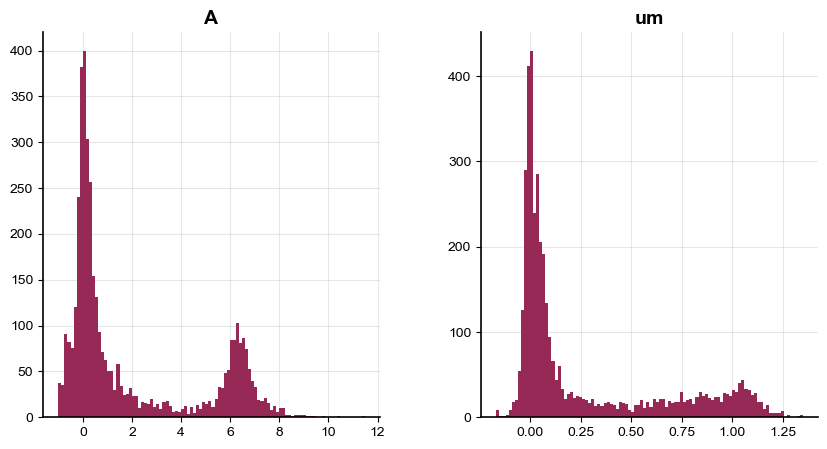

In [8]:
gene_level_LFCs[["A", "um"]].hist(bins=100, figsize=(10,5))
plt.show()
plt.close()

In [9]:
UTR_insertion_in_nonWT_genes = UTR_insertion_LFCs.query("(um_gene > 0.5)").copy()
in_gene_insertion_in_nonWT_genes = in_gene_insertion_LFCs.query("(um_gene > 0.5)").copy()

# 5.Plot

In [21]:
def plot_UTR_gene_boundary_insertions(UTR_insertions, gene_insertions, feature="um_ratio"):


    fig, axes = plt.subplots(1,4, figsize=(12,5))

    UTR_5 = UTR_insertions.query("UTR_type == '5UTR'").copy()
    N_terminal_insertions = gene_insertions.query(f"Distance_to_start_codon < {distance_threshold}").copy()
    N_terminal_insertions["Distance_to_gene_boundary"] = N_terminal_insertions["Distance_to_start_codon"]
    C_terminal_insertions = gene_insertions.query(f"Distance_to_stop_codon < {distance_threshold}").copy()
    C_terminal_insertions["Distance_to_gene_boundary"] = -C_terminal_insertions["Distance_to_stop_codon"]
    UTR_3 = UTR_insertions.query("UTR_type == '3UTR'").copy()

    titles = ["Upstream", "N-terminus", "C-terminus", "Downstream"]
    for col, col_data in enumerate([UTR_5, N_terminal_insertions, C_terminal_insertions, UTR_3]):
        ax = axes[col]
        # boxplot with bins
        width = 10
        x_bins = range(-300, 301, width)
        if col == 0:
            ax.set_xlabel("Distance to start codon (bp)", fontsize=12)
            # ax.set_xticks(np.arange(-300, 0, width))
            # ax.set_xticklabels(np.arange(-300, 0, width))
        elif col == 1:
            ax.set_xlabel("Distance to start codon (bp)", fontsize=12)
        elif col == 2:
            ax.set_xlabel("Distance to stop codon (bp)", fontsize=12)
        elif col == 3:
            ax.set_xlabel("Distance to stop codon (bp)", fontsize=12)

        
        col_data["bin"] = pd.cut(col_data["Distance_to_gene_boundary"], bins=x_bins)
        col_data["bin_mid"] = col_data["bin"].map(lambda x: x.mid)
        grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
        grouped_data = grouped_data[grouped_data.map(len) > 1]
        positions = grouped_data.index.tolist()
        boxplot_values = grouped_data.values.tolist()
        bp = ax.boxplot(boxplot_values, positions=positions, widths=width*0.8, patch_artist=True, boxprops=dict(facecolor="grey", alpha=0.5), showfliers=False)

        # for box in bp["boxes"]:
        #     box.set_facecolor("none")
        #     box.set_edgecolor("black")
        #     box.set_linewidth(2)
        for median in bp["medians"]:
            median.set_color("black")
            median.set_linewidth(2)

        ax.set_xticks([])
        x_data = col_data["Distance_to_gene_boundary"]
        y_data = col_data[feature]
        # ax.scatter(x_data, y_data, alpha=0.4, s=5, facecolor="none", edgecolor="grey")
        ax.set_title(titles[col])
        ax.set_ylim(-0.5, 1.45)
       
        ax.tick_params(axis="both", which="both", bottom=True, left=True, labelbottom=True, labelleft=True, labelsize=12)
        ax.axhline(0, color="green", linestyle="-", linewidth=2, alpha=0.2)
        ax.axhline(1, color="red", linestyle="-", linewidth=2, alpha=0.2)
        if col > 0:
            ax.spines[["left", "top", "right"]].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines[["top", "right"]].set_visible(False)
            ax.set_ylabel("DR ratio (insertion/gene)", fontsize=12)



    plt.show()
    plt.close()

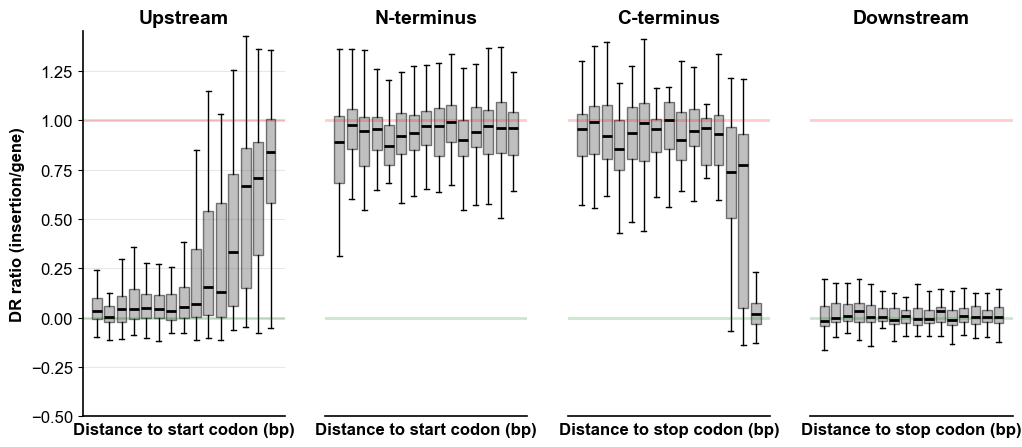

In [22]:
plot_UTR_gene_boundary_insertions(UTR_insertion_in_nonWT_genes, in_gene_insertion_in_nonWT_genes)

In [12]:
Pair_UTR_insertion_in_nonWT_genes = UTR_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()
Pair_in_gene_insertion_in_nonWT_genes = in_gene_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()

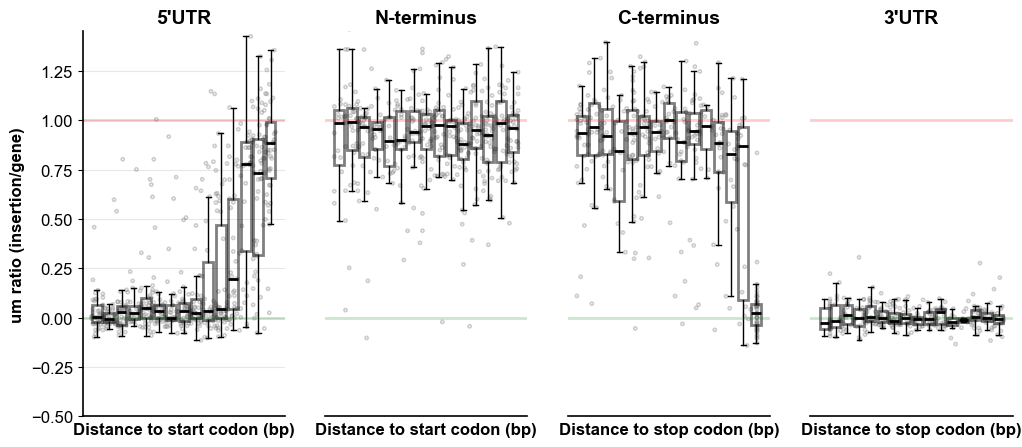

In [13]:
Forward_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
Forward_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
plot_UTR_gene_boundary_insertions(Forward_UTR_insertion_in_nonWT_genes, Forward_in_gene_insertion_in_nonWT_genes)

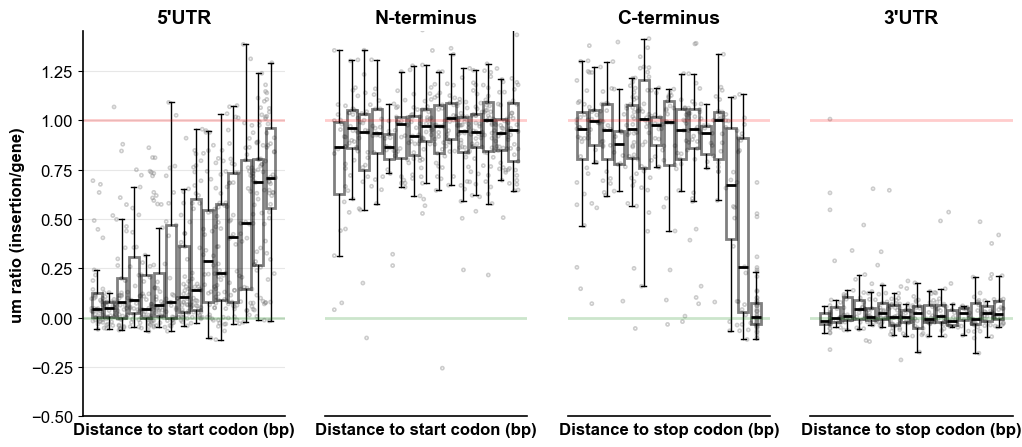

In [14]:
Reverse_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
Reverse_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
plot_UTR_gene_boundary_insertions(Reverse_UTR_insertion_in_nonWT_genes, Reverse_in_gene_insertion_in_nonWT_genes)